## Definición del problema:  

Calcular la tasa de conversión de ventas que tiene la compañía de polizas Homesite ("https://go.homesite.com/") caracterizando los clientes y las pólizas. 
Para ello contamos con diferentes características del posible cliente y el objeivo es optimizar el ratio de éxito cuando se lleve a cabo una campaña o cuando llegue un nuevo cliente

### Carga de librerias necesarias

In [1]:
# Tratamiento de datos
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
pd.options.display.max_columns = None

# Gráficos 
###########
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px 
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Modelado y Forecasting 
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#Configuracion de Warnings
import warnings 
warnings.filterwarnings('ignore')

### Carga inicial de datos y preprocesamiento de algunas variables 

In [2]:
archivo = 'C:/Users/Usuario/Desktop/IBC/MASTER CUNEF/train.csv'

In [3]:
df = pd.read_csv(archivo)
df = df.iloc[:,np.r_[0:10,43:72,11:35,126:146,173:198]]
df.head(10)

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,0,0,-1,-1,7,0,N,1,2,5,7,0,1,2,2,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,5,7,-1,19,N,N,Y,0,O,0,0,1,-1,21,4,2,C,4,14,22,3,6,15,14,12,13,20,22,-1,13,2,5,1,1,1,1,2,9,-1,25,1,1,1,1,1
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,1,1,14,19,7,0,N,1,2,24,25,0,1,2,5,19,XB,YJ,YE,XT,1,0,0,0,0,0,1,1,0,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,17,21,-1,22,N,N,Y,0,N,0,0,1,-1,23,3,0,B,4,7,15,8,17,19,20,12,14,16,18,-1,19,4,13,9,13,5,13,5,12,-1,25,4,15,8,13,5
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,1,1,16,21,7,0,N,1,2,7,16,0,1,2,3,7,ZH,XS,YP,XC,1,0,0,0,0,0,1,1,0,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,12,16,-1,13,Y,Y,Y,0,R,1,0,1,-1,21,4,2,C,4,9,17,2,4,20,22,18,20,16,18,-1,21,4,12,10,14,5,13,6,14,-1,25,4,11,9,15,5
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,1,1,2,2,6,1,N,1,3,-1,-1,0,5,2,3,13,XO,XE,YI,XX,1,0,0,0,0,0,1,1,0,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,1,1,-1,2,N,N,Y,0,R,1,0,1,-1,21,4,2,C,1,3,6,2,3,10,8,8,9,21,23,-1,23,13,21,22,22,14,21,18,21,-1,25,15,22,21,22,15
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,1,1,20,24,7,0,N,1,2,5,8,0,1,2,2,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,10,13,-1,19,Y,Y,Y,0,D,0,0,1,-1,21,1,2,A,4,5,11,2,2,17,18,13,15,9,7,-1,13,9,18,11,16,9,17,12,17,-1,25,9,17,12,16,9
5,12,2014-01-18,0,E,14,0.9472,0.0006,"1,487",1.3045,N,0,0,9,12,7,0,N,1,2,4,3,0,3,2,5,13,YE,XU,XQ,ZQ,3,1,1,1,1,2,3,3,1,20,13,20,17,23,12,20,13,22,1,6,Y,A,5,10,25,25,25,25,0,4,3,20,R,10,13,-1,3,N,N,Y,0,R,1,0,1,-1,24,1,2,C,4,4,6,7,15,6,4,15,18,20,22,-1,13,10,18,12,18,10,18,16,19,-1,25,9,18,13,18,10
6,13,2013-11-01,0,J,23,0.9258,0.0004,"1,165",1.2665,N,0,0,-1,-1,6,1,N,1,2,20,23,0,1,2,2,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0,23,17,23,15,22,16,22,13,22,13,23,T,G,2,2,15,24,7,20,0,5,5,7,V,8,12,-1,9,N,N,Y,0,S,0,0,1,-1,21,4,2,C,2,4,8,7,15,18,19,19,21,13,13,-1,13,24,25,24,25,24,25,25,25,-1,25,24,25,25,25,24
7,14,2014-05-14,0,B,25,0.9153,0.0007,935,1.0200,N,1,1,2,2,7,0,N,1,3,-1,-1,0,5,2,3,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0,8,5,8,5,6,5,7,1,2,13,23,X,D,25,25,1,1,2,3,1,5,5,11,T,7,11,-1,24,N,N,Y,0,D,1,0,1,-1,21,4,2,C,1,3,6,5,11,7,4,2,1,18,20,-1,13,1,1,8,9,2,8,2,6,-1,25,2,2,6,9,2
8,18,2013-06-

### Análisis general de la tabla

Dimensión

In [4]:
print(df.shape)

(260753, 108)


Tipo de datos

In [5]:
df.dtypes

QuoteNumber              int64
Original_Quote_Date     object
QuoteConversion_Flag     int64
Field6                  object
Field7                   int64
                         ...  
GeographicField11A       int64
GeographicField11B       int64
GeographicField12A       int64
GeographicField12B       int64
GeographicField13A       int64
Length: 108, dtype: object

Media en % de filas (clientes) que contienen algún dato nulo

In [6]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0007439991102691052


Número de NaN por columna 

In [7]:
df.isnull().sum().sort_values(ascending = False) #Vemos que solo hay tres columnas con datos nulos

PersonalField7        113
PropertyField3         81
PropertyField4         63
PropertyField5          0
PropertyField14         0
                     ... 
PersonalField25         0
PersonalField24         0
PersonalField23         0
PersonalField22         0
GeographicField13A      0
Length: 108, dtype: int64

Viendo que las tres columnas con datos NaN son binarias con datos "Y" (yes) y "N" (No), voy a suponer que los que faltan son "N" y por tanto voy a nombrar a esos valoeres NaN como "N" para así eliminar todos los valores nulos de la tabla

In [8]:
df = df.fillna("N")

In [9]:
df = df.drop(["QuoteNumber"], axis = 1) # Elimino esta variable 

### Exploración de la variable objetivo

In [10]:
df_plot_conversion_status = df['QuoteConversion_Flag']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()
df_conversion_status_conteo = df['QuoteConversion_Flag'].value_counts().reset_index()
df_plot_conversion_status_pc = pd.merge(df_plot_conversion_status, df_conversion_status_conteo, on=['index'], how='inner')
df_plot_conversion_status_pc  # Vemos que la proporción es de un 80/20 más o menos, siendo los que no contratan la póliza los más numerosos

,index,percent,QuoteConversion_Flag
0,0,81.248921,211859
1,1,18.751079,48894


# 1.- Para hacer una posterior evaluación de los métodos desarrollados, divide el dataset extraído del fichero train.csv en training, validation y test. 
### Recomendamos además generar sendas listas de variables que hacen referencias a los clientes y las que hacen referencia a los productos (pudiendo generar dos datasets distintos), la unión de ambos nos interesa fundamentalmente de cara a evaluar la conversión.

In [11]:
dftrain, dfvalidate, dftest = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])
print("Ejemplos usados para entrenar: ", len(dftrain))
print("Ejemplos usados para validar: ", len(dfvalidate))
print("Ejemplos usados para test: ", len(dftest))

Ejemplos usados para entrenar:  156451
Ejemplos usados para validar:  52151
Ejemplos usados para test:  52151


In [12]:
variables_clientes = list(df.iloc[:, :38].columns)

In [13]:
variables_poliza = list(df.filter(regex='Sales|Property|Geographic|Coverage').columns)

# 2.- Realiza las acciones adecuadas sobre el dataset de clientes
* 2.1 Realiza una transformación adecuada del dataset con las variables de clientes para su posterior procesamiento. (Tips: recuerda eliminar ids, transformar variables discretas, y cambiar fechas a días hasta el día actual, por ejemplo.)

 * 2.2.- ¿Debes normalizar los datos?. Si es así, realiza la normalización. 
 * 2.3.- Puede ser interesante realizar un análisis descriptivo con algún mapa de correlación y un t-sne, pca o similar para ver cómo se distribuyen los datos y eliminar outliers (recuerda eliminarlos también de la tabla que relaciona clientes y pólizas)
 * 2.4.- Haz un clustering haciendo uso de alguna de las técnicas de clustering vistas en clase, de la base del dataset de pólizas. Recuerda optimizar el valor adecuado de grupos e indicar el porqué de la técnica elegida.

In [14]:
df_cliente = df.iloc[:, :38]
df_cliente.head()

,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30
0,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,0,0,-1,-1,7,0,N,1,2,5,7,0,1,2,2,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0
1,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,1,1,14,19,7,0,N,1,2,24,25,0,1,2,5,19,XB,YJ,YE,XT,1,0,0,0,0,0,1,1,0
2,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,1,1,16,21,7,0,N,1,2,7,16,0,1,2,3,7,ZH,XS,YP,XC,1,0,0,0,0,0,1,1,0
3,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,1,1,2,2,6,1,N,1,3,-1,-1,0,5,2,3,13,XO,XE,YI,XX,1,0,0,0,0,0,1,1,0
4,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,1,1,20,24,7,0,N,1,2,5,8,0,1,2,2,24,ZA,ZE,XR,XD,1,0,0,0,0,1,2,2,0


In [15]:
df_cliente.dtypes

Original_Quote_Date      object
QuoteConversion_Flag      int64
Field6                   object
Field7                    int64
Field8                  float64
Field9                  float64
Field10                  object
Field11                 float64
Field12                  object
PersonalField1            int64
PersonalField2            int64
PersonalField4A           int64
PersonalField4B           int64
PersonalField5            int64
PersonalField6            int64
PersonalField7           object
PersonalField8            int64
PersonalField9            int64
PersonalField10A          int64
PersonalField10B          int64
PersonalField11           int64
PersonalField12           int64
PersonalField13           int64
PersonalField14           int64
PersonalField15           int64
PersonalField16          object
PersonalField17          object
PersonalField18          object
PersonalField19          object
PersonalField22           int64
PersonalField23           int64
Personal

### Tratamiento de Original_Quote_Date
* Le restamos la fecha actual para pasar a una columna numérica

Text(0, 0.5, 'Frequency')

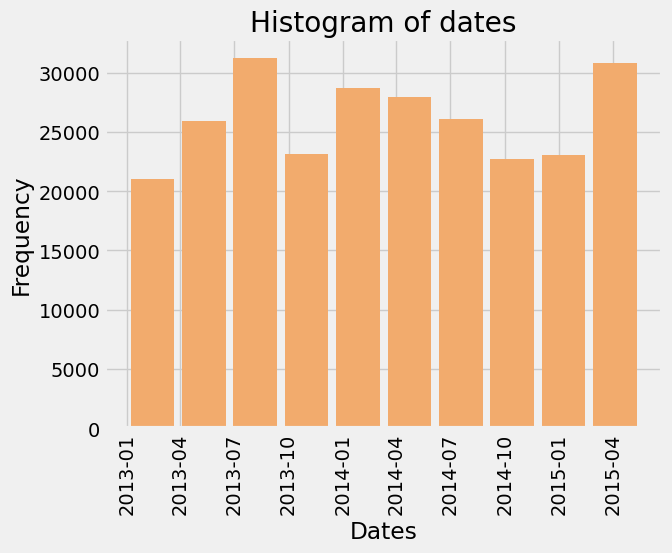

In [16]:
df_cliente["Original_Quote_Date"] = pd.to_datetime(df_cliente['Original_Quote_Date'], format = '%Y-%m-%d')

plt.hist(x= df_cliente.Original_Quote_Date, color='#F2AB6D', rwidth=0.85)
plt.title('Histogram of dates')
plt.xticks(rotation=90)
plt.xlabel('Dates')
plt.ylabel("Frequency")

In [17]:
df_cliente["Original_Quote_Date"] = df_cliente.apply(lambda x: (datetime.now() - x['Original_Quote_Date']).days ,axis=1) # Convierto la fecha a los dias hasta fecha actual

### Tratamiento de Field10
* Retiro coma para pasar la columna a numérica

In [18]:
df_cliente["Field10"] = df_cliente["Field10"].str.replace(",", "", regex = False).astype(int)

### Tratamiento de PersonalField16, PersonalField17, PersonalField18 y PersonalField19
* Estas cuatro columnas tienen demasiados valores distintos como se puede ver. Lo que voy a hacer ees eliminarlas porque pienso que el valor que aportan puede ser muy lioso para el modelo

In [19]:
print("En esta variable de PersonalField16 hay un total de " + str(len(df_cliente["PersonalField16"].value_counts())))

En esta variable de PersonalField16 hay un total de 50


In [20]:
print("Lo mismo voy a hacer con la columna PersonalField17 que tiene " + str(len(df_cliente["PersonalField17"].value_counts())) + ", con la variable PersonalField18 que tiene " + str(len(df_cliente["PersonalField18"].value_counts())) + " y con la variable PersonalField19 que tiene " + str(len(df_cliente["PersonalField19"].value_counts())) + " valores únicos")

Lo mismo voy a hacer con la columna PersonalField17 que tiene 66, con la variable PersonalField18 que tiene 61 y con la variable PersonalField19 que tiene 57 valores únicos


In [21]:
df_cliente = df_cliente.drop(['PersonalField16', 'PersonalField17', 'PersonalField18', 'PersonalField19'], axis = 1)

### One Hot Encoding de la tabla clientes

In [22]:
features_categoricas_cliente = ["Field6", "Field12", "PersonalField7"]

In [23]:
df_cliente = pd.get_dummies(df_cliente, columns = features_categoricas_cliente)
print(df_cliente.shape)

(260753, 43)


In [24]:
df_cliente.head()

,Original_Quote_Date,QuoteConversion_Flag,Field7,Field8,Field9,Field10,Field11,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,Field6_A,Field6_B,Field6_C,Field6_D,Field6_E,Field6_F,Field6_J,Field6_K,Field12_N,Field12_Y,PersonalField7_N,PersonalField7_Y
0,3448,0,23,0.9403,0.0006,965,1.0200,0,0,-1,-1,7,0,1,2,5,7,0,1,2,2,24,1,0,0,0,0,1,2,2,0,0,1,0,0,0,0,0,0,1,0,1,0
1,3199,0,7,1.0006,0.0040,548,1.2433,1,1,14,19,7,0,1,2,24,25,0,1,2,5,19,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0
2,3074,0,7,1.0006,0.0040,548,1.2433,1,1,16,21,7,0,1,2,7,16,0,1,2,3,7,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0
3,3571,0,10,0.9769,0.0004,1165,1.2665,1,1,2,2,6,1,1,3,-1,-1,0,5,2,3,13,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0
4,3286,0,23,0.9472,0.0006,1487,1.3045,1,1,20,24,7,0,1,2,5,8,0,1,2,2,24,1,0,0,0,0,1,2,2,0,0,0,0,0,1,0,0,0,1,0,1,0


### Análisis de correlación

<AxesSubplot:>

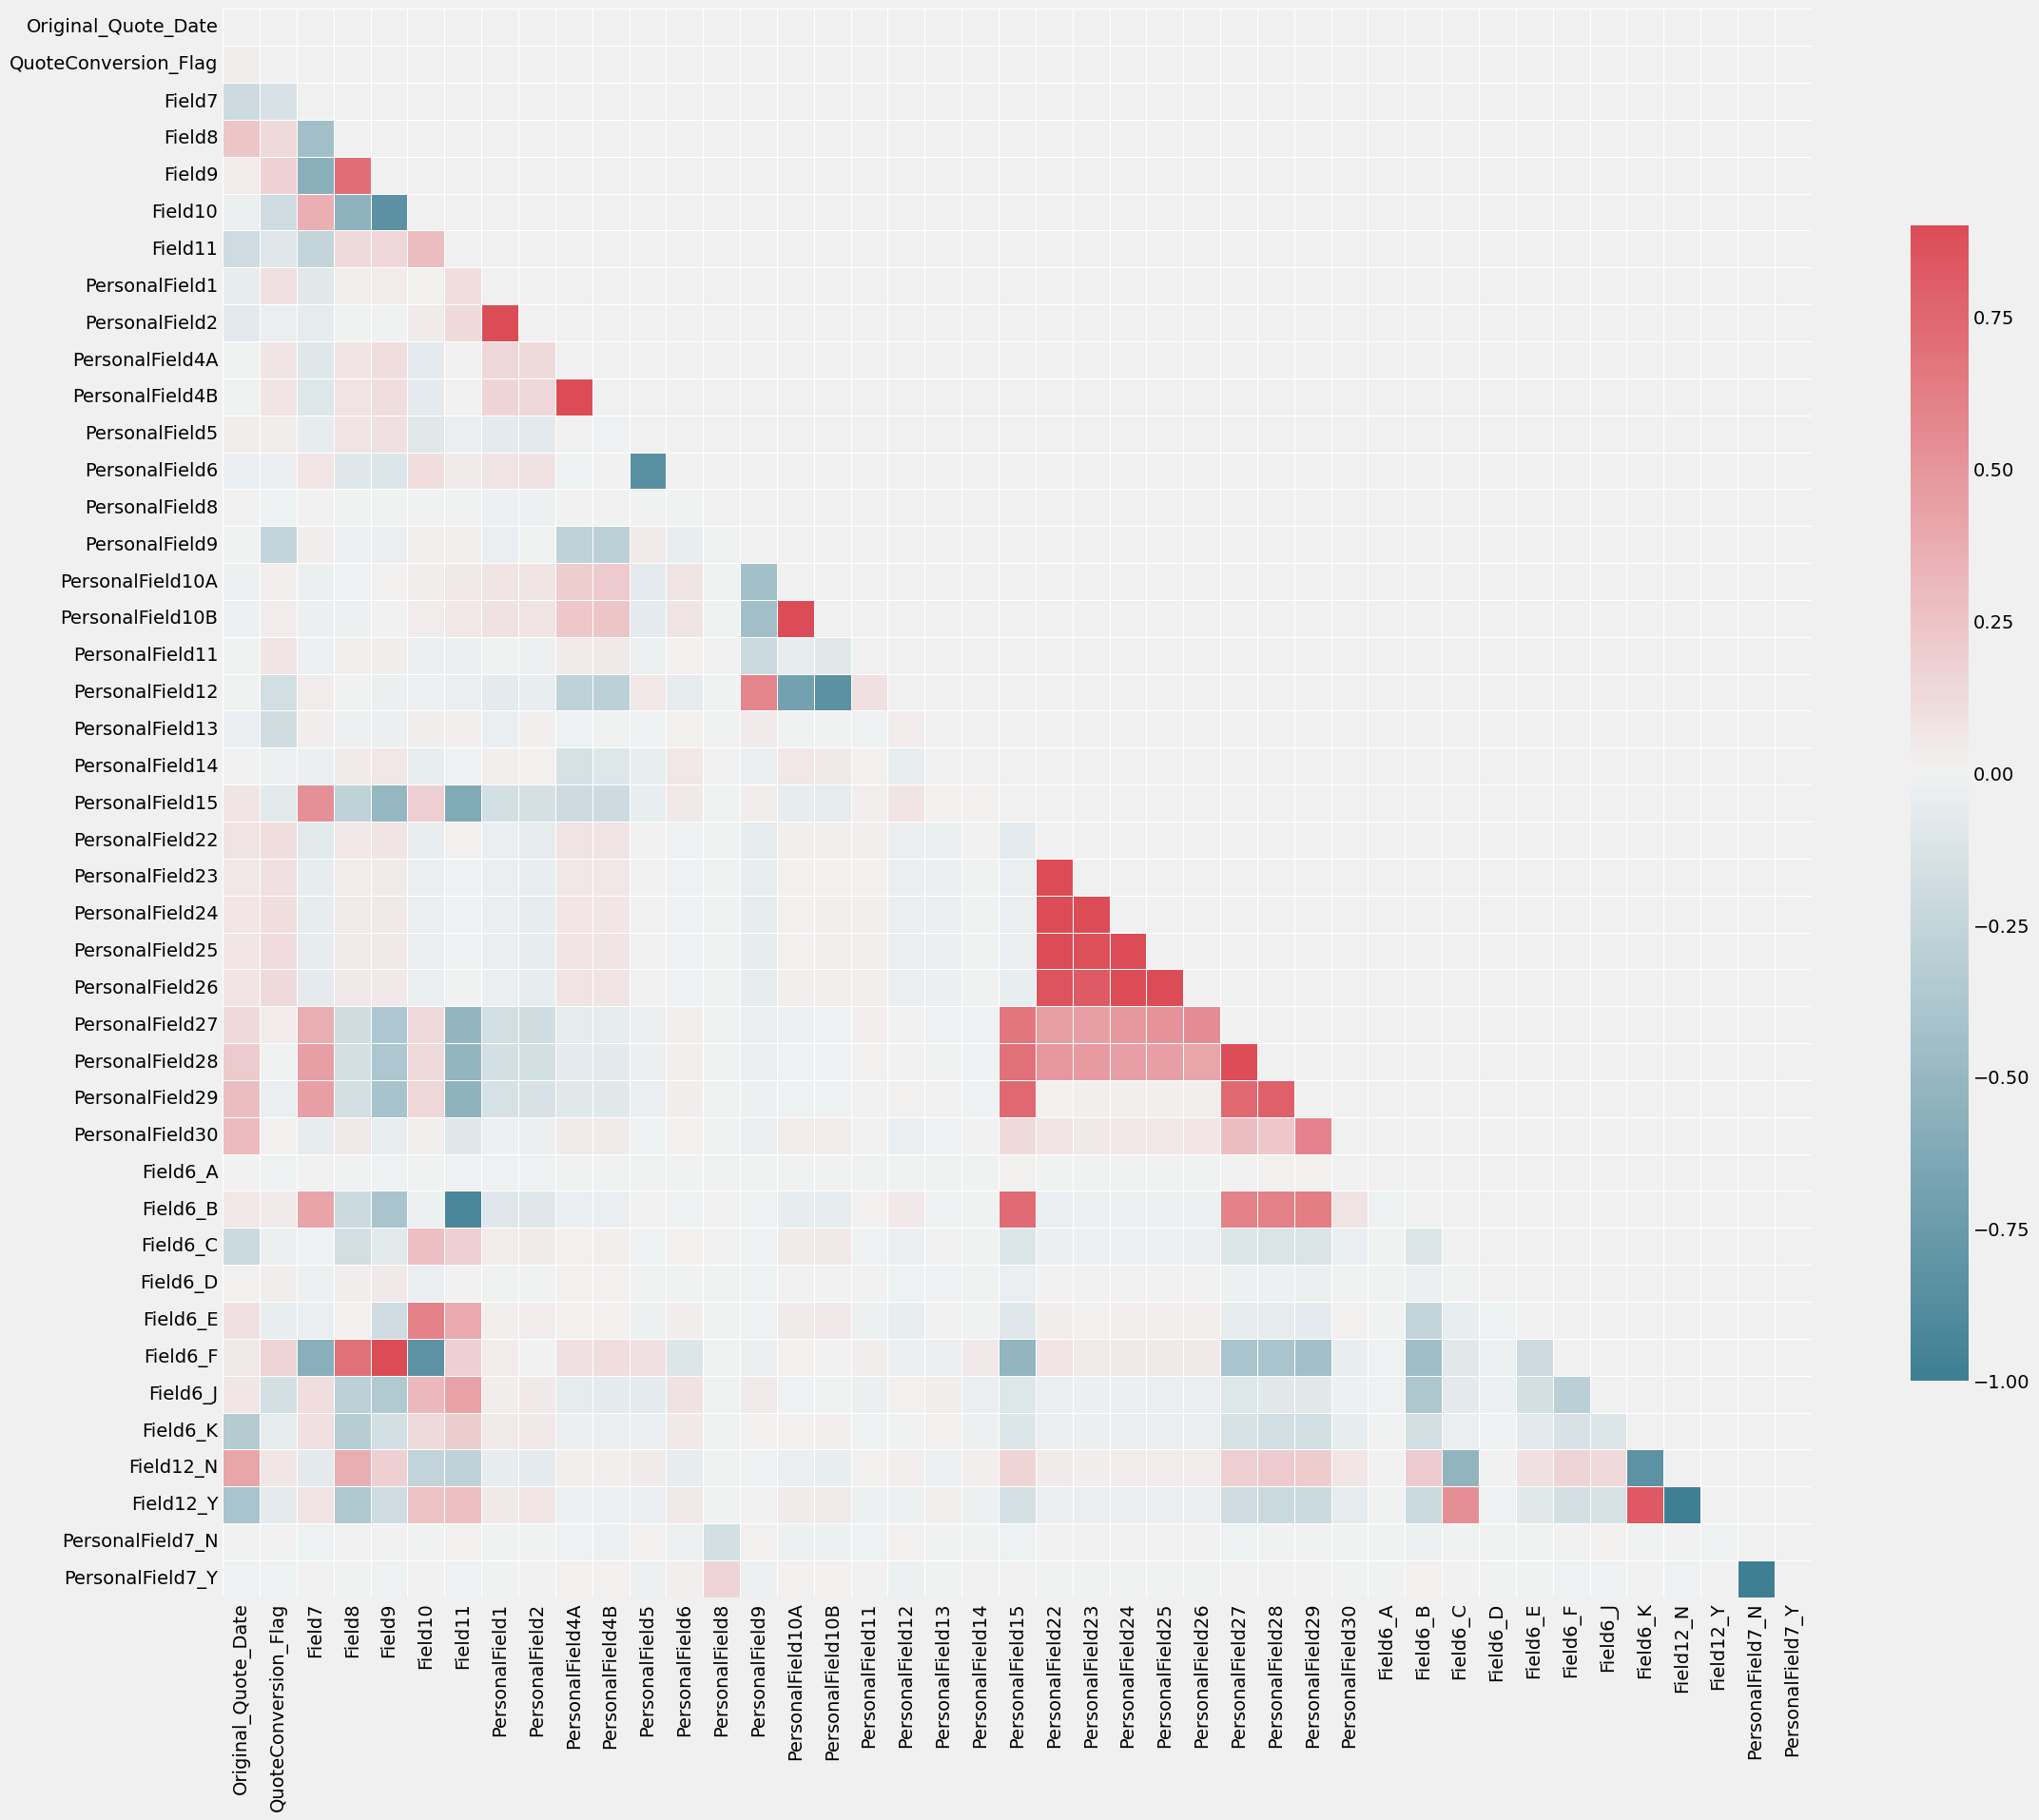

In [25]:
#Veamos la relación que hay entre las variables con la correlación visualmente
corr = df_cliente.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (24, 30))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .9, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})


* Vemos como casi todas las correlaciones más cercanas a 1 se encuentran cerca de la diagonal principal en las columnas de PersonalField23 a PersonalField30. Por lo que afirmamos que estas variables tienen mucha relacion entre sí. <br>
Apenas encontramos variables inversamente correlacionadas cercanas a -1. <br>
Es interesante ver que valores de PersonalField16_ZA, PersonalField17_ZE, PersonalField18_XR y PersonalField19_XD estan muy correlacionados con las mismas variables todos ellos. <br>

### Análsis descriptivo

In [26]:
df_cliente.describe(include='all')

,Original_Quote_Date,QuoteConversion_Flag,Field7,Field8,Field9,Field10,Field11,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,Field6_A,Field6_B,Field6_C,Field6_D,Field6_E,Field6_F,Field6_J,Field6_K,Field12_N,Field12_Y,PersonalField7_N,PersonalField7_Y
count,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000,260753.000000
mean,3235.783485,0.187511,18.293339,0.938346,0.001451,954.110829,1.162718,0.726515,0.699156,9.729763,11.940726,6.630781,0.370278,1.000150,2.152236,6.922586,10.138595,0.023563,2.204285,1.992177,2.954420,16.165919,1.049330,0.025702,0.031747,0.036901,0.044195,0.548941,1.510610,1.522184,0.055965,0.000134,0.363156,0.021706,0.000920,0.099953,0.264821,0.198586,0.050722,0.927571,0.072429,0.995164,0.004836
std,247.962904,0.390322,7.382803,0.037086,0.001486,290.571712,0.116833,0.445748,0.458626,6.821498,8.003960,0.568167,0.482880,0.012539,0.494768,6.738417,8.573812,0.160741,1.663651,0.090847,1.349083,8.164436,0.345003,0.232619,0.263228,0.286833,0.320752,0.621003,0.567467,0.604798,0.246379,0.011585,0.480910,0.145723,0.030324,0.299938,0.441239,0.398937,0.219431,0.259197,0.259197,0.069373,0.069373
min,2808.000000,0.000000,1.000000,0.874600,0.000400,548.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3024.000000,0.000000,11.000000,0.915300,0.000600,564.000000,1.020000,0.000000,0.000000,5.000000,5.000000,6.000000,0.000000,1.000000,2.000000,4.000000,2.000000,0.000000,1.000000,2.000000,2.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,3241.000000,0.000000,23.000000,0.940300,0.000600,965.000000,1.188600,1.000000,1.000000,9.000000,12.000000,7.000000,0.000000,1.000000,2.000000,6.000000,10.000000,0.000000,1.000000,2.000000,3.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,3451.000000,0.000000,24.000000,0.968500,0.003800,1113.000000,1.266500,1.000000,1.000000,14.000000,19.000000,7.000000,1.000000,1.000000,2.000000,9.000000,18.000000,0.000000,4.000000,2.000000,4.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,3675.000000,1.000000,28.000000,1.010100,0.004000,1487.000000,1.304500,1.000000,1.000000,25.000000,25.000000,10.000000,1.000000,3.000000,3.000000,25.000000,25.000000,4.000000,5.000000,4.000000,54.000000,24.000000,7.000000,14.000000,14.000000,14.000000,14.000000,23.000000,7.000000,7.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA de Cliente sobre Train

In [27]:
df_cliente_train = df_cliente[df_cliente.index.isin(list(dftrain.index))] # Solo me quedo con las de Train que he definido al principio
df_cliente_test = df_cliente[df_cliente.index.isin(list(dftest.index))]

In [28]:
features = list(df_cliente_train.columns)
x = df_cliente_train.loc[:, features].values
scaler_train_cliente = StandardScaler().fit(x)
xs_train = scaler_train_cliente.transform(x)

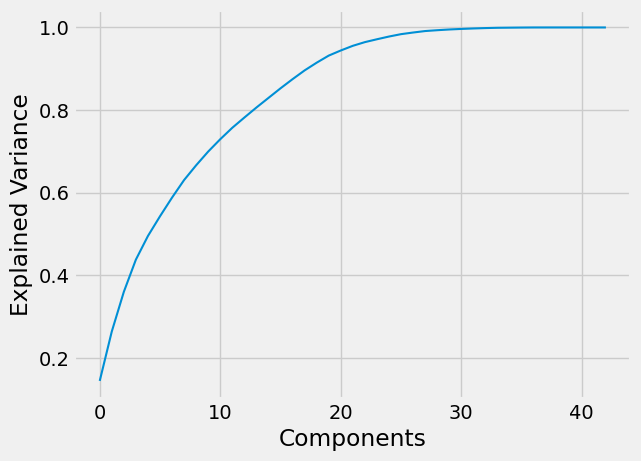

In [29]:
pca = PCA()
pca_xs = pca.fit(xs_train)
var_threshold = 0.7
var_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_explained)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [30]:
# Es decir, de las 43 variables que teniamos después de hacer la transformación, 
# Somos capaces de explicar el 90% de la varianza con tan solo  19
var_explained[:19] 

array([0.14467604, 0.26418348, 0.3602139 , 0.43817669, 0.49537344,
       0.54301542, 0.58827902, 0.63075461, 0.66647473, 0.69965952,
       0.72949179, 0.7572367 , 0.78195849, 0.806214  , 0.82947224,
       0.85269556, 0.87487115, 0.89606091, 0.91473315])

In [31]:
df_cliente_componets = pd.DataFrame(data = pca_xs.components_, 
                                    columns = df_cliente_train.columns)
df_cliente_componets.head()

,Original_Quote_Date,QuoteConversion_Flag,Field7,Field8,Field9,Field10,Field11,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,Field6_A,Field6_B,Field6_C,Field6_D,Field6_E,Field6_F,Field6_J,Field6_K,Field12_N,Field12_Y,PersonalField7_N,PersonalField7_Y
0,0.082125,-0.002466,0.197975,-0.120784,-0.213512,0.097787,-0.241085,-0.089611,-0.088600,-0.044589,-0.046298,-0.012051,0.012713,0.001762,-0.001423,-0.023975,-0.024432,0.006335,0.019603,-0.001466,-0.005941,0.296106,0.185874,0.188555,0.194350,0.195566,0.189342,0.369223,0.371102,0.307314,0.106553,0.003603,0.279559,-0.056547,-0.009135,-0.015544,-0.223088,-0.017360,-0.073251,0.093812,-0.093812,-0.003498,0.003498
1,0.084981,0.117730,-0.219473,0.245792,0.288350,-0.231729,0.045420,0.015157,-0.005388,0.113646,0.115221,0.043132,-0.048861,-0.001718,-0.076369,0.049786,0.051893,0.021019,-0.069868,-0.026818,0.010271,-0.179124,0.315842,0.300896,0.312201,0.313944,0.306117,0.045903,0.031794,-0.113475,0.016478,-0.002272,-0.122707,-0.067833,0.014179,-0.019406,0.287677,-0.070980,-0.110833,0.131960,-0.131960,0.004674,-0.004674
2,-0.183526,-0.032980,0.059369,-0.230018,-0.181123,0.262920,0.231611,0.073585,0.080886,0.060186,0.062099,-0.076073,0.084594,-0.000889,-0.066249,0.111756,0.121480,-0.013774,-0.107167,0.011158,-0.017402,-0.114764,0.192745,0.194805,0.199994,0.199141,0.191099,0.005227,-0.015597,-0.128831,-0.053159,-0.002303,-0.166385,0.204394,-0.007071,0.094369,-0.168458,0.084492,0.287244,-0.358102,0.358102,-0.004688,0.004688
3,-0.047708,-0.080817,-0.026910,-0.001228,0.031284,-0.009340,0.089474,-0.110882,-0.098593,-0.281159,-0.288230,0.078612,-0.081886,-0.005898,0.345803,-0.419259,-0.444663,-0.000958,0.440088,0.018452,-0.008814,-0.047189,0.094488,0.098429,0.099600,0.097214,0.088612,-0.018287,-0.025065,-0.097257,-0.071272,-0.000108,-0.092648,0.024773,-0.004378,-0.020712,0.037829,0.032799,0.079971,-0.081601,0.081601,0.029337,-0.029337
4,-0.215896,0.121323,0.024756,0.004241,0.171275,-0.316030,-0.293543,-0.087812,-0.104305,0.028817,0.027164,0.110162,-0.117558,0.012503,-0.059466,0.010937,0.008648,0.035263,-0.022576,-0.026981,0.009495,0.086316,-0.026428,-0.022604,-0.022158,-0.022174,-0.022036,0.052140,0.033904,0.038994,-0.029466,0.001113,0.230801,0.132129,0.008535,-0.346091,0.154728,-0.395833,0.284722,-0.315269,0.315269,-0.036350,0.036350


In [32]:
df_cliente_componets[:1].T.sort_values(by = [0], ascending = False).head(10)

,0
PersonalField28,0.371102
PersonalField27,0.369223
PersonalField29,0.307314
PersonalField15,0.296106
Field6_B,0.279559
Field7,0.197975
PersonalField25,0.195566
PersonalField24,0.194350
PersonalField26,0.189342
PersonalField23,0.188555


##### Conclusiones
* La primera componente explica el 14,46% de la varianza total y está explicada por las variables: PersonalField28, PersonalField27, PersonalField29, PersonalField15 y Field6_B
* La segunda componente explica el 11,95% de la varianza total y está explicada por las variables: PersonalField22, PersonalField25, PersonalField24, PersonalField26 y PersonalField23
* La tercera componente explica el 9,6% de a varianza total y está explicada por las variables: Field12_Y, Field6_K, Field10, Field11 y Field6_C
* Es decir, las primeras dos variables se explican con la información que proporcinan las variables que en el gráfico de correlación que veíamos más arriba se encuentran en rojo, es decir están muy correlacionadas entre si. A partir de la 3, la varianza deja de estar explicada casi únicamente con estas variables para dar paso al resto. 
* Cabe destacar que solo con 5 componentes de las 43, se puede explicar el 50% de la varianza total gracias al análisis PCA

### Clustering

In [33]:
scaler = MinMaxScaler()
 
df_clientes_n= pd.DataFrame(scaler.fit_transform(df_cliente_train),
                         columns=df_cliente_train.columns, index=df_cliente_train.index) 

df_clientes_test= pd.DataFrame(scaler.fit_transform(df_cliente_test),
                         columns=df_cliente_test.columns, index=df_cliente_test.index) 

df_clientes_n

,Original_Quote_Date,QuoteConversion_Flag,Field7,Field8,Field9,Field10,Field11,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,Field6_A,Field6_B,Field6_C,Field6_D,Field6_E,Field6_F,Field6_J,Field6_K,Field12_N,Field12_Y,PersonalField7_N,PersonalField7_Y
0,0.738178,0.0,0.814815,0.484871,0.055556,0.444089,0.065681,0.0,0.0,0.000000,0.000000,0.666667,0.0,0.0,0.5,0.230769,0.307692,0.0,0.0,0.333333,0.020408,1.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.166667,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.450980,0.0,0.222222,0.929889,1.000000,0.000000,0.799015,1.0,1.0,0.576923,0.769231,0.666667,0.0,0.0,0.5,0.961538,1.000000,0.0,0.0,0.333333,0.081633,0.782609,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.880046,0.0,0.333333,0.754982,0.000000,0.657082,0.875205,1.0,1.0,0.115385,0.115385,0.555556,1.0,0.0,1.0,0.000000,0.000000,0.0,1.0,0.333333,0.040816,0.521739,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.551326,0.0,0.814815,0.535793,0.055556,1.000000,1.000000,1.0,1.0,0.807692,0.961538,0.666667,0.0,0.0,0.5,0.230769,0.346154,0.0,0.0,0.333333,0.020408,1.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,0.649366,0.0,0.814815,0.377860,0.000000,0.657082,0.875205,0.0,0.0,0.000000,0.000000,0.555556,1.0,0.0,0.5,0.807692,0.923077,0.0,0.0,0.333333,0.020408,1.000000,0.0,0.0,0.0,0.0,0.0,0.043478,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260746,0.334487,0.0,0.222222,0.929889,1.000000,0.000000,0.799015,1.0,1.0,0.846154,0.961538,0.666667,0.0,0.0,0.5,0.192308,0.153846,0.0,0.5,0.333333,0.000000,0.608696,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
260749,0.186851,0.0,0.925926,0.091513,0.000000,0.601704,0.875205,1.0,1.0,0.307692,0.346154,0.666667,0.0,0.0,1.0,0.000000,0.000000,0.0,1.0,0.333333,0.040816,0.521739,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
260750,0.523645,0.0,0.370370,0.692989,1.000000,0.000000,0.619376,1.0,1.0,0.192308,0.192308,0.666667,0.0,0.0,1.0,0.000000,0.000000,0.0,1.0,0.333333,0.020408,0.217391,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
260751,0.467128,0.0,0.222222,0.929889,1.000000,0.000000,0.799015,1.0,1.0,0.615385,0.807692,0.666667,0.0,0.0,0.5,0.653846,0.884615,0.0,0.0,0.333333,0.020408,0.217391,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


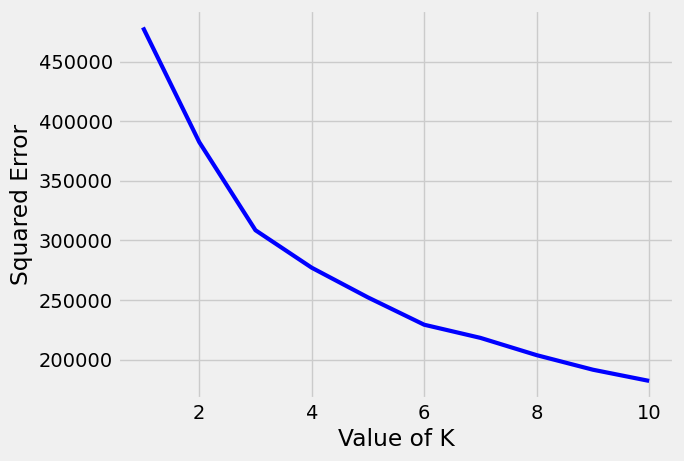

In [34]:
numeroK = []
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(df_clientes_n)
    numeroK.append(KM.inertia_)    

    
plt.plot(range(1, 11), numeroK, color ='b', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error")
plt.show()

##### Voy a utilizar 4 clusters ya que a partir de este número la curva se suaviza

In [35]:
kmeans_cliente = KMeans(n_clusters=4).fit(df_clientes_n)
centroids = kmeans_cliente.cluster_centers_
etiquetas = kmeans_cliente.labels_
centroids

array([[ 5.17331113e-01,  2.98638507e-01,  3.76902545e-01,
         7.86184392e-01,  9.75780974e-01,  7.42819955e-03,
         6.52951194e-01,  7.54017127e-01,  7.02035024e-01,
         4.54658831e-01,  5.49327765e-01,  6.35510547e-01,
         2.79948042e-01,  7.21639565e-05,  5.63865102e-01,
         3.12267317e-01,  4.33692426e-01,  7.72154335e-03,
         2.84945396e-01,  3.29252061e-01,  4.24112972e-02,
         3.45649664e-01,  1.53027679e-02,  3.07899548e-03,
         3.80407142e-03,  4.36763756e-03,  5.21985952e-03,
         5.77102481e-03,  2.13845858e-02,  1.39316527e-02,
         1.66742475e-03, -1.49077799e-19, -3.43058915e-14,
         2.03656536e-15,  3.41576061e-03, -5.81479309e-15,
         9.96584239e-01, -1.59594560e-14,  1.94289029e-15,
         1.00000000e+00, -5.38458167e-15,  9.96055037e-01,
         3.94496296e-03],
       [ 5.13888491e-01,  2.09362284e-01,  7.92949607e-01,
         3.95074238e-01,  7.09435363e-02,  4.26401262e-01,
         6.40771363e-02,  6.65

In [36]:
df_clientes_n["cluster_clientes"] = kmeans_cliente.predict(df_clientes_n)

In [37]:
df_clientes_number_cluster = df_clientes_n.groupby("cluster_clientes")[["QuoteConversion_Flag"]].agg('count')
df_clientes_number_cluster.rename(columns = {"QuoteConversion_Flag": "Count"})

,Count
cluster_clientes,
0,41572
1,57016
2,46550
3,11313


# 3.- Realiza las acciones adecuadas sobre el dataset de poliza
 * 3.1 Transformación del dataset si es necesario.
 * 3.2 Normaliza si es necesario.
 * 3.3 Quizá sea interesante un pequeño análisis descriptivo.
 * 3.4 Haz un clustering haciendo uso de alguna de las técnicas de clustering vistas en clase, de la base del dataset de campañas. Recuerda optimizar el valor adecuado de grupos e indicar el porqué de la técnica elegida.

In [38]:
df_poliza = df.filter(regex='Sales|Property|Geographic|Coverage')
df_poliza.head()

,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A
0,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,5,7,-1,19,N,N,Y,0,O,0,0,1,-1,21,4,2,C,4,14,22,3,6,15,14,12,13,20,22,-1,13,2,5,1,1,1,1,2,9,-1,25,1,1,1,1,1
1,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,17,21,-1,22,N,N,Y,0,N,0,0,1,-1,23,3,0,B,4,7,15,8,17,19,20,12,14,16,18,-1,19,4,13,9,13,5,13,5,12,-1,25,4,15,8,13,5
2,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,12,16,-1,13,Y,Y,Y,0,R,1,0,1,-1,21,4,2,C,4,9,17,2,4,20,22,18,20,16,18,-1,21,4,12,10,14,5,13,6,14,-1,25,4,11,9,15,5
3,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,1,1,-1,2,N,N,Y,0,R,1,0,1,-1,21,4,2,C,1,3,6,2,3,10,8,8,9,21,23,-1,23,13,21,22,22,14,21,18,21,-1,25,15,22,21,22,15
4,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,10,13,-1,19,Y,Y,Y,0,D,0,0,1,-1,21,1,2,A,4,5,11,2,2,17,18,13,15,9,7,-1,13,9,18,11,16,9,17,12,17,-1,25,9,17,12,16,9


In [39]:
df_poliza.dtypes

CoverageField1B       int64
CoverageField2A       int64
CoverageField2B       int64
CoverageField3A       int64
CoverageField3B       int64
                      ...  
GeographicField11A    int64
GeographicField11B    int64
GeographicField12A    int64
GeographicField12B    int64
GeographicField13A    int64
Length: 69, dtype: object

#####
* Con el siguiente código lo que hago es eliminar las dobles parejas que hay en el dataset de pólizas y quedandome, haciendo una redución dimensional, con la mitad de los componentes. <br> Es decir, con parejas como CoverageField11A y CoverageField11B hago una redución para solo quedarme con una nueva columna llamada CoverageField11 que explique la máxima varianza posible. Esta varianza se puede ver a  contunuación ya que hago un print para saber cuanto consigo explicar de cada una


In [40]:
[i for i in df_poliza.columns if i.endswith('B')]

['CoverageField1B',
 'CoverageField2B',
 'CoverageField3B',
 'CoverageField4B',
 'CoverageField5B',
 'CoverageField6B',
 'CoverageField11B',
 'SalesField1B',
 'SalesField2B',
 'PropertyField1B',
 'PropertyField2B',
 'PropertyField11B',
 'PropertyField16B',
 'GeographicField1B',
 'GeographicField2B',
 'GeographicField3B',
 'GeographicField4B',
 'GeographicField5B',
 'GeographicField6B',
 'GeographicField7B',
 'GeographicField8B',
 'GeographicField9B',
 'GeographicField10B',
 'GeographicField11B',
 'GeographicField12B']

In [44]:
lista_A = [i for i in df_poliza.columns if i.endswith('A')][:-1]
lista_B = [i for i in df_poliza.columns if i.endswith('B')][1:]
lista_rep = sorted((lista_A  + lista_B)) #Ya tengo las columnas a la par
scaled_features_poliza = StandardScaler().fit_transform(df_poliza[lista_rep].values)
scaled_features_df_poliza = pd.DataFrame(scaled_features_poliza, index=df_poliza.index, columns=df_poliza[lista_rep].columns)
scaled_features_df_poliza.head() # Ya tengo la tabla Estandarizada

i = 0  #Itero sobre las columnas por parejas, les aplico un PCA y saco solo la primera componente 
while i <=46: 
    pca_poliza = PCA(n_components=2)
    pca_poliza_xs = pca_poliza.fit(scaled_features_df_poliza.iloc[:, i:(i+2)].values)
    pComponents_poliza_xs = pca_poliza_xs.transform(scaled_features_df_poliza.iloc[:, i:(i+2)].values)
    var_explained = np.cumsum(pca_poliza.explained_variance_ratio_)
    df_poliza_ = pd.DataFrame(data = pComponents_poliza_xs, 
                                columns = [scaled_features_df_poliza.iloc[:, i:(i+2)].columns[0], 
                                           scaled_features_df_poliza.iloc[:, i:(i+2)].columns[1]])
    print("la varianza explicada es por el primer componente de " + str(df_poliza_.columns[1][:-1]) + " es " + str(round(var_explained[0], 3)))
    scaled_features_df_poliza[df_poliza_.columns[1][:-1]] = df_poliza_.iloc[:, 0].values
    i += 2

scaled_features_df_poliza = scaled_features_df_poliza.iloc[:, -24:]  

la varianza explicada es por el primer componente de CoverageField11 es 0.954
la varianza explicada es por el primer componente de CoverageField2 es 0.969
la varianza explicada es por el primer componente de CoverageField3 es 0.97
la varianza explicada es por el primer componente de CoverageField4 es 0.968
la varianza explicada es por el primer componente de CoverageField5 es 0.886
la varianza explicada es por el primer componente de CoverageField6 es 0.943
la varianza explicada es por el primer componente de GeographicField10 es 1.0
la varianza explicada es por el primer componente de GeographicField11 es 0.932
la varianza explicada es por el primer componente de GeographicField12 es 0.981
la varianza explicada es por el primer componente de GeographicField1 es 0.952
la varianza explicada es por el primer componente de GeographicField2 es 0.996
la varianza explicada es por el primer componente de GeographicField3 es 0.996
la varianza explicada es por el primer componente de Geographic

In [45]:
print(scaled_features_df_poliza.shape)
scaled_features_df_poliza.head() # Esta tengo la nueva tabla sin duplicidades de columnas A y B

(260753, 24)


,CoverageField11,CoverageField2,CoverageField3,CoverageField4,CoverageField5,CoverageField6,GeographicField10,GeographicField11,GeographicField12,GeographicField1,GeographicField2,GeographicField3,GeographicField4,GeographicField5,GeographicField6,GeographicField7,GeographicField8,GeographicField9,PropertyField11,PropertyField16,PropertyField1,PropertyField2,SalesField1,SalesField2
0,-1.944588,1.989464,1.635383,1.778287,-0.001053,-0.518837,-0.00277,-1.837837,2.097397,-1.267470,-0.261904,0.007150,1.742225,-0.661486,-1.357856,2.169475,-1.900503,-1.049450,-0.390277,1.697419,-1.196694,0.439389,0.596092,-0.874687
1,-0.763603,-0.880109,-1.102717,-0.997722,-0.001053,-0.518837,-0.00277,-0.157393,0.278493,0.484486,-1.308173,0.105154,0.859979,0.388408,-0.359121,0.239471,-0.297810,-0.475619,0.996043,0.103397,1.526539,0.742296,-0.068269,0.528716
2,-1.189779,-0.360743,-0.681826,-0.448366,-2.096696,-0.518837,-0.00277,-0.551597,-0.009323,-1.598238,-1.618412,1.371474,0.859979,0.738372,-0.457787,0.046867,-0.297810,-0.185594,-0.390277,0.558832,0.473885,-0.166425,-0.732631,-0.439513
3,1.937481,-1.849906,-1.973174,-1.841614,-0.001053,-0.518837,-0.00277,1.635137,-1.798747,-1.696355,0.899917,-0.837063,1.962786,1.088337,1.372540,-1.875203,1.425876,1.615996,-0.390277,-1.297765,-2.235681,-1.277084,0.830159,2.248221
4,-1.189779,-0.135528,-0.457043,-0.252009,-0.001053,-0.518837,-0.00277,0.540924,-0.383251,-1.794472,-0.882382,0.316207,-1.076186,-0.661486,0.657728,-0.243030,0.512305,0.665827,-0.390277,-0.548155,-0.045608,0.439389,-1.125089,-1.070451


##### Ahora trateré de procesar aquellas columnas que no he procesado todavía del dataset de polizas

In [46]:
lista_no_rep = [i for i in df_poliza.columns if not (i.endswith('A') | i.endswith('B'))]
df_poliza_no_rep = df_poliza[lista_no_rep]

In [47]:
df_poliza_no_rep

,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField14,PropertyField15
0,T,D,0,5,5,24,V,N,N,Y,0,O,0,0,1,4,2,C,4
1,T,E,1,5,5,11,P,N,N,Y,0,N,0,0,1,3,0,B,4
2,T,J,1,5,5,11,K,Y,Y,Y,0,R,1,0,1,4,2,C,4
3,Y,F,0,5,5,23,V,N,N,Y,0,R,1,0,1,4,2,C,1
4,T,F,1,5,5,7,R,Y,Y,Y,0,D,0,0,1,1,2,A,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260748,T,G,1,5,5,1,Q,N,N,Y,0,R,0,0,1,4,2,C,4
260749,X,G,1,5,4,11,T,N,N,Y,0,J,1,0,1,4,2,C,4
260750,T,E,1,5,5,11,P,N,N,Y,0,R,1,0,1,1,1,A,4
260751,Y,E,0,1,2,20,K,Y,Y,Y,0,R,1,0,1,1,2,C,4


#### 
* Estas dos columnas tienen demasiados valores distintos. Lo que voy a hacer ees eliminarlas porque pienso que el valor que aportan puede ser muy lioso para el modelo

In [48]:
df_poliza_no_rep = df_poliza_no_rep.drop(['CoverageField9', 'PropertyField7'], axis = 1)

### One Hot Encoding de la tabla póliza

In [49]:
df_poliza_no_rep

,CoverageField8,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField14,PropertyField15
0,T,0,5,5,24,V,N,N,Y,0,0,0,1,4,2,C,4
1,T,1,5,5,11,P,N,N,Y,0,0,0,1,3,0,B,4
2,T,1,5,5,11,K,Y,Y,Y,0,1,0,1,4,2,C,4
3,Y,0,5,5,23,V,N,N,Y,0,1,0,1,4,2,C,1
4,T,1,5,5,7,R,Y,Y,Y,0,0,0,1,1,2,A,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260748,T,1,5,5,1,Q,N,N,Y,0,0,0,1,4,2,C,4
260749,X,1,5,4,11,T,N,N,Y,0,1,0,1,4,2,C,4
260750,T,1,5,5,11,P,N,N,Y,0,1,0,1,1,1,A,4
260751,Y,0,1,2,20,K,Y,Y,Y,0,1,0,1,1,2,C,4


In [50]:
features_categoricas_poliza = ["CoverageField8", "SalesField7", "PropertyField3", "PropertyField4", "PropertyField5", "PropertyField14"]

In [51]:
df_poliza_no_rep = pd.get_dummies(df_poliza_no_rep, columns = features_categoricas_poliza)
print(df_poliza_no_rep.shape)

(260753, 35)


In [52]:
df_poliza_no_rep.head()

,SalesField3,SalesField4,SalesField5,SalesField6,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField15,CoverageField8_T,CoverageField8_U,CoverageField8_V,CoverageField8_W,CoverageField8_X,CoverageField8_Y,CoverageField8_Z,SalesField7_K,SalesField7_M,SalesField7_P,SalesField7_Q,SalesField7_R,SalesField7_T,SalesField7_V,PropertyField3_N,PropertyField3_Y,PropertyField4_N,PropertyField4_Y,PropertyField5_N,PropertyField5_Y,PropertyField14_A,PropertyField14_B,PropertyField14_C,PropertyField14_D
0,0,5,5,24,0,0,0,1,4,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0
1,1,5,5,11,0,0,0,1,3,0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,1,5,5,11,0,1,0,1,4,2,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0
3,0,5,5,23,0,1,0,1,4,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0
4,1,5,5,7,0,0,0,1,1,2,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0


### Estandarizo la tabla de polizas que aun no he estandarizado todavía, es decir la df_poliza_no_rep

In [53]:
scaled_features_poliza_no_rep = StandardScaler().fit_transform(df_poliza_no_rep[list(df_poliza_no_rep.columns)].values)
scaled_features_df_poliza_no_rep = pd.DataFrame(scaled_features_poliza_no_rep, index=df_poliza_no_rep.index, columns=df_poliza_no_rep[list(df_poliza_no_rep.columns)].columns)
scaled_features_df_poliza_no_rep.head()

,SalesField3,SalesField4,SalesField5,SalesField6,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField15,CoverageField8_T,CoverageField8_U,CoverageField8_V,CoverageField8_W,CoverageField8_X,CoverageField8_Y,CoverageField8_Z,SalesField7_K,SalesField7_M,SalesField7_P,SalesField7_Q,SalesField7_R,SalesField7_T,SalesField7_V,PropertyField3_N,PropertyField3_Y,PropertyField4_N,PropertyField4_Y,PropertyField5_N,PropertyField5_Y,PropertyField14_A,PropertyField14_B,PropertyField14_C,PropertyField14_D
0,-1.709070,0.640936,0.793529,1.587808,0.0,-1.410714,-0.007265,-0.068059,0.814587,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.30072,-1.103299,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,2.411935,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
1,0.585113,0.640936,0.793529,-0.476581,0.0,-1.410714,-0.007265,-0.068059,0.032383,-2.147139,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.30072,-1.103299,-0.058819,-0.488650,-0.256062,2.072286,-0.432035,-0.294259,-0.457641,-0.414605,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,2.835399,-1.732427,-0.012991
2,0.585113,0.640936,0.793529,-0.476581,0.0,0.708861,-0.007265,-0.068059,0.814587,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.30072,-1.103299,-0.058819,2.046455,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,-0.414605,-2.595400,2.595400,-2.562283,2.562283,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
3,-1.709070,0.640936,0.793529,1.429009,0.0,0.708861,-0.007265,-0.068059,0.814587,0.333215,-1.400990,-0.749419,-0.04281,-0.039878,-0.039587,-0.30072,0.906373,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,2.411935,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
4,0.585113,0.640936,0.793529,-1.111777,0.0,-1.410714,-0.007265,-0.068059,-1.532026,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.30072,-1.103299,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,3.398363,-0.457641,-0.414605,-2.595400,2.595400,-2.562283,2.562283,-0.021097,0.021097,2.487535,-0.352684,-1.732427,-0.012991


### Uno finalmente las dos tablas: la primera procesada con valores duplicados A y B y esta nueva. Ambas tablas ya estandarizadas

In [54]:
df_poliza_scaled = pd.merge(scaled_features_df_poliza, scaled_features_df_poliza_no_rep, left_index=True, right_index=True)
df_poliza_scaled

,CoverageField11,CoverageField2,CoverageField3,CoverageField4,CoverageField5,CoverageField6,GeographicField10,GeographicField11,GeographicField12,GeographicField1,GeographicField2,GeographicField3,GeographicField4,GeographicField5,GeographicField6,GeographicField7,GeographicField8,GeographicField9,PropertyField11,PropertyField16,PropertyField1,PropertyField2,SalesField1,SalesField2,SalesField3,SalesField4,SalesField5,SalesField6,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField15,CoverageField8_T,CoverageField8_U,CoverageField8_V,CoverageField8_W,CoverageField8_X,CoverageField8_Y,CoverageField8_Z,SalesField7_K,SalesField7_M,SalesField7_P,SalesField7_Q,SalesField7_R,SalesField7_T,SalesField7_V,PropertyField3_N,PropertyField3_Y,PropertyField4_N,PropertyField4_Y,PropertyField5_N,PropertyField5_Y,PropertyField14_A,PropertyField14_B,PropertyField14_C,PropertyField14_D
0,-1.944588,1.989464,1.635383,1.778287,-0.001053,-0.518837,-0.00277,-1.837837,2.097397,-1.267470,-0.261904,0.007150,1.742225,-0.661486,-1.357856,2.169475,-1.900503,-1.049450,-0.390277,1.697419,-1.196694,0.439389,0.596092,-0.874687,-1.709070,0.640936,0.793529,1.587808,0.0,-1.410714,-0.007265,-0.068059,0.814587,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.300720,-1.103299,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,2.411935,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
1,-0.763603,-0.880109,-1.102717,-0.997722,-0.001053,-0.518837,-0.00277,-0.157393,0.278493,0.484486,-1.308173,0.105154,0.859979,0.388408,-0.359121,0.239471,-0.297810,-0.475619,0.996043,0.103397,1.526539,0.742296,-0.068269,0.528716,0.585113,0.640936,0.793529,-0.476581,0.0,-1.410714,-0.007265,-0.068059,0.032383,-2.147139,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.300720,-1.103299,-0.058819,-0.488650,-0.256062,2.072286,-0.432035,-0.294259,-0.457641,-0.414605,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,2.835399,-1.732427,-0.012991
2,-1.189779,-0.360743,-0.681826,-0.448366,-2.096696,-0.518837,-0.00277,-0.551597,-0.009323,-1.598238,-1.618412,1.371474,0.859979,0.738372,-0.457787,0.046867,-0.297810,-0.185594,-0.390277,0.558832,0.473885,-0.166425,-0.732631,-0.439513,0.585113,0.640936,0.793529,-0.476581,0.0,0.708861,-0.007265,-0.068059,0.814587,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.300720,-1.103299,-0.058819,2.046455,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,-0.414605,-2.595400,2.595400,-2.562283,2.562283,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
3,1.937481,-1.849906,-1.973174,-1.841614,-0.001053,-0.518837,-0.00277,1.635137,-1.798747,-1.696355,0.899917,-0.837063,1.962786,1.088337,1.372540,-1.875203,1.425876,1.615996,-0.390277,-1.297765,-2.235681,-1.277084,0.830159,2.248221,-1.709070,0.640936,0.793529,1.429009,0.0,0.708861,-0.007265,-0.068059,0.814587,0.333215,-1.400990,-0.749419,-0.04281,-0.039878,-0.039587,-0.300720,0.906373,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,-0.294259,-0.457641,2.411935,0.385297,-0.385297,0.390277,-0.390277,-0.021097,0.021097,-0.402004,-0.352684,0.577225,-0.012991
4,-1.189779,-0.135528,-0.457043,-0.252009,-0.001053,-0.518837,-0.00277,0.540924,-0.383251,-1.794472,-0.882382,0.316207,-1.076186,-0.661486,0.657728,-0.243030,0.512305,0.665827,-0.390277,-0.548155,-0.045608,0.439389,-1.125089,-1.070451,0.585113,0.640936,0.793529,-1.111777,0.0,-1.410714,-0.007265,-0.068059,-1.532026,0.333215,0.283569,1.334367,-0.04281,-0.039878,-0.039587,-0.300720,-1.103299,-0.058819,-0.488650,-0.256062,-0.482559,-0.432035,3.398363,-0.457641,-0.414605,-2.595400,2.595400,-2.562283,2.562283,-0.021097,0.021097,2.487535,-0.352684,-1.732427,-0.012991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260748,-1

### Análsis de correlación

<AxesSubplot:>

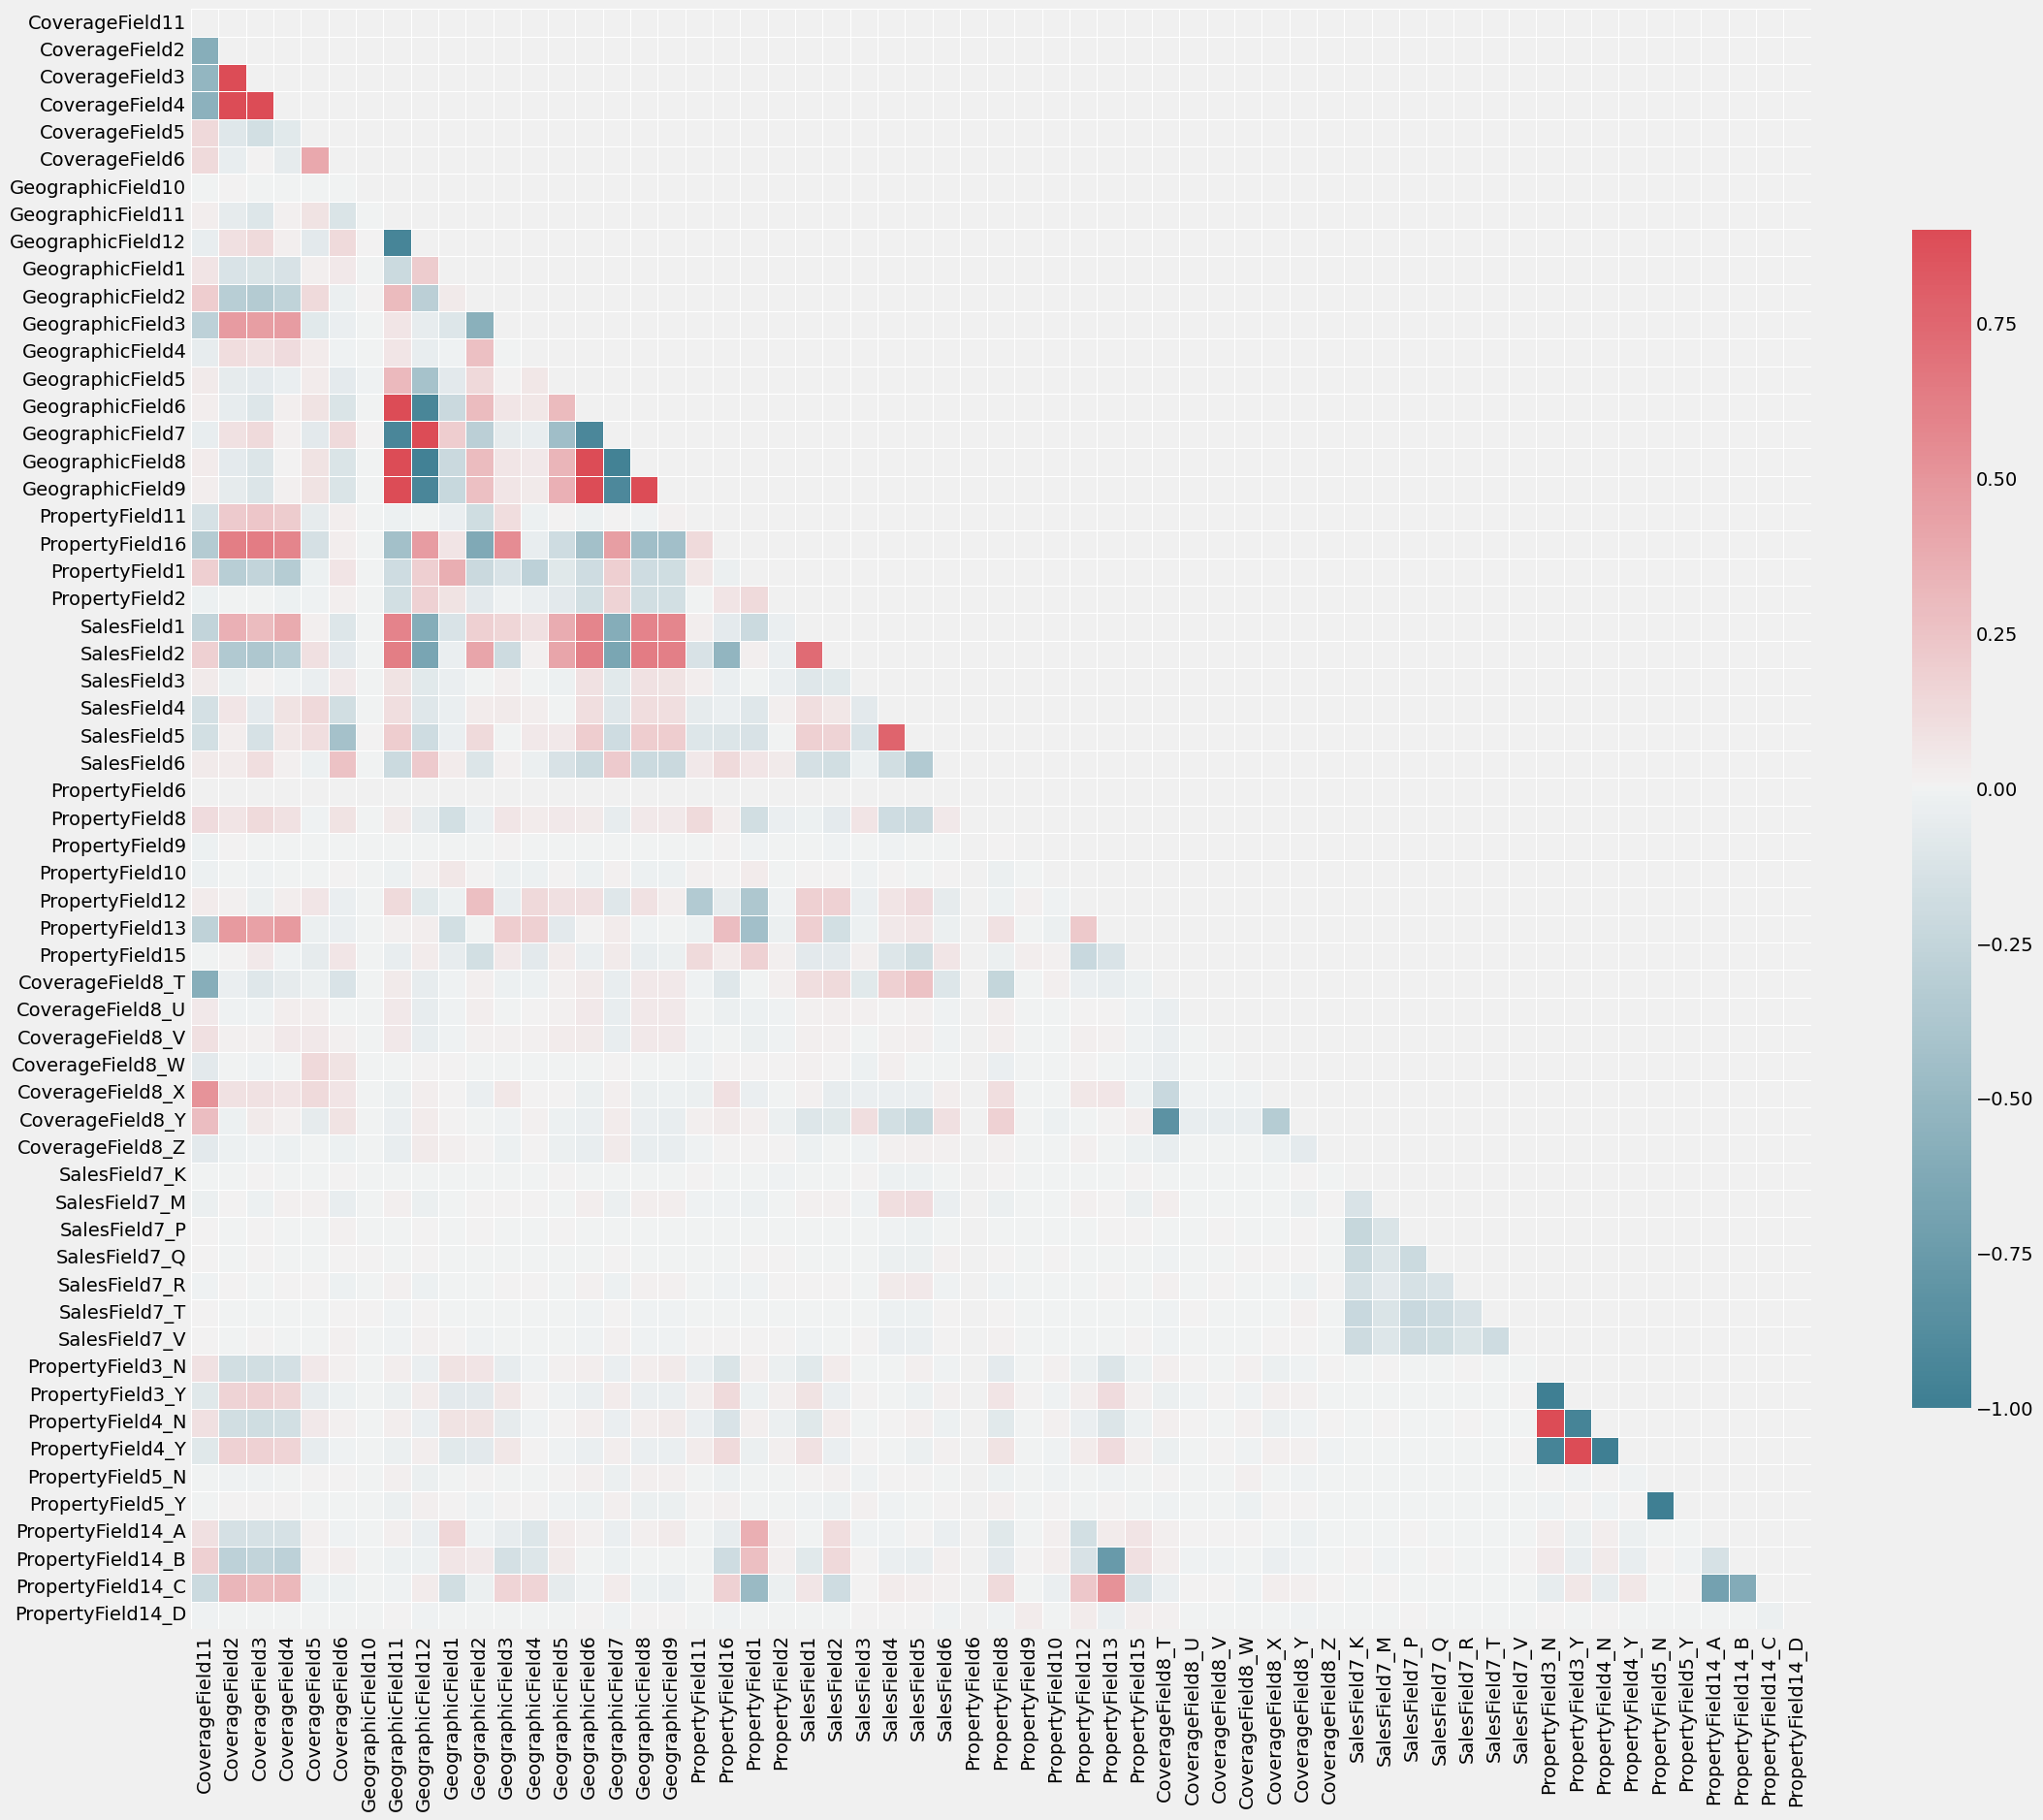

In [55]:
#Veamos la relación que hay entre las variables con la correlación visualmente
corr = df_poliza_scaled.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (24, 30))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .9, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})


### Análisis PCA de las variables de Poliza

In [56]:
df_poliza_train = df_poliza_scaled[df_poliza_scaled.index.isin(list(dftrain.index))]
df_poliza_test = df_poliza_scaled[df_poliza_scaled.index.isin(list(dftest.index))]

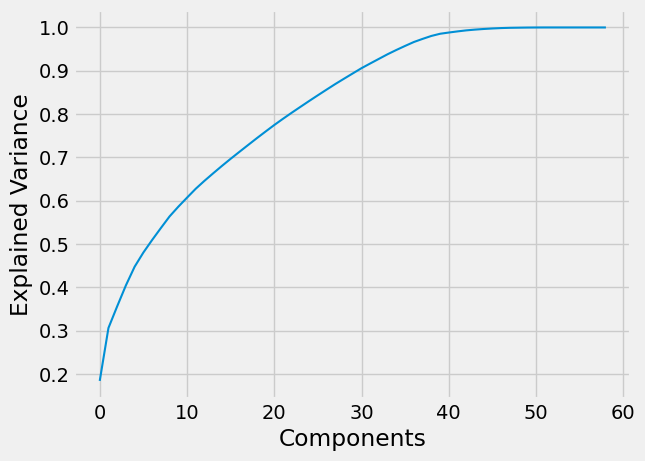

In [57]:
pca_poliza = PCA()
pca_poliza_xs = pca_poliza.fit(df_poliza_train.values)
var_threshold = 0.7
var_explained_poliza = np.cumsum(pca_poliza_xs.explained_variance_ratio_)
plt.plot(var_explained_poliza)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [58]:
# Es decir, de las 59 variables que teniamos después de hacer la transformación, 
# Somos capaces de explicar el 90% de la varianza con tan solo 31
var_explained_poliza[:31] 

array([0.18420537, 0.30640073, 0.3563733 , 0.40474963, 0.44781431,
       0.48049784, 0.50934203, 0.53687412, 0.56380958, 0.58616196,
       0.6071031 , 0.6277129 , 0.64602157, 0.66337608, 0.68037   ,
       0.69684686, 0.71280065, 0.72864499, 0.74438751, 0.75972314,
       0.77483897, 0.78922213, 0.80320854, 0.81679298, 0.83031536,
       0.84355874, 0.85660512, 0.86951676, 0.88180899, 0.8939796 ,
       0.90606081])

In [59]:
df_poliza_components = pd.DataFrame(data = pca_poliza_xs.components_, 
                                    columns = df_poliza_train.columns)
df_poliza_components.head()

,CoverageField11,CoverageField2,CoverageField3,CoverageField4,CoverageField5,CoverageField6,GeographicField10,GeographicField11,GeographicField12,GeographicField1,GeographicField2,GeographicField3,GeographicField4,GeographicField5,GeographicField6,GeographicField7,GeographicField8,GeographicField9,PropertyField11,PropertyField16,PropertyField1,PropertyField2,SalesField1,SalesField2,SalesField3,SalesField4,SalesField5,SalesField6,PropertyField6,PropertyField8,PropertyField9,PropertyField10,PropertyField12,PropertyField13,PropertyField15,CoverageField8_T,CoverageField8_U,CoverageField8_V,CoverageField8_W,CoverageField8_X,CoverageField8_Y,CoverageField8_Z,SalesField7_K,SalesField7_M,SalesField7_P,SalesField7_Q,SalesField7_R,SalesField7_T,SalesField7_V,PropertyField3_N,PropertyField3_Y,PropertyField4_N,PropertyField4_Y,PropertyField5_N,PropertyField5_Y,PropertyField14_A,PropertyField14_B,PropertyField14_C,PropertyField14_D
0,0.048262,-0.091833,-0.110182,-0.063197,0.042166,-0.050487,-0.000765,0.338207,-0.352775,-0.074382,0.174058,-0.040344,0.029611,0.132044,0.339364,-0.349906,0.346179,0.339900,-0.027827,-0.227120,-0.069464,-0.050851,0.216916,0.278760,0.013687,0.033590,0.066517,-0.067058,0.000000e+00,0.004893,-0.000524,-0.004346,0.040154,-0.021077,-0.020806,0.022464,0.012691,0.011604,-0.000516,-0.009604,-0.017065,-0.010649,-0.000419,0.007803,-0.000873,-0.001190,0.003606,-0.001312,-0.003999,0.020052,-0.020052,0.020127,-0.020127,0.007105,-0.007105,0.011097,0.015777,-0.020377,0.002585
1,-0.278230,0.410357,0.388541,0.409018,-0.062232,-0.058106,0.000701,0.086962,-0.075557,-0.122212,-0.146809,0.278766,0.064336,0.021303,0.088220,-0.075826,0.084443,0.085195,0.089129,0.249661,-0.207391,-0.021690,0.214223,-0.076113,-0.000991,0.033352,0.031153,-0.012069,0.000000e+00,0.040068,0.001913,-0.006183,0.022529,0.177743,-0.006084,0.015961,0.003494,0.006432,-0.000961,0.002390,-0.016921,-0.004538,-0.000460,0.006441,-0.000231,-0.002192,0.003752,-0.002186,-0.001883,-0.082700,0.082700,-0.084708,0.084708,-0.000245,0.000245,-0.063402,-0.122612,0.139539,-0.001098
2,0.018396,-0.012869,0.027920,-0.014703,-0.099239,0.020094,-0.003229,0.069486,-0.088217,0.095176,-0.407765,0.244994,-0.365223,0.033754,0.074925,-0.086072,0.083355,0.098589,0.185956,0.144307,0.465795,0.032777,0.026215,0.036124,0.031346,-0.074020,-0.099414,0.032251,-3.155444e-30,-0.015483,0.002518,0.015916,-0.248905,-0.210824,0.159618,-0.011199,-0.001858,-0.004674,-0.006943,-0.006699,0.017968,-0.020115,0.001627,-0.013962,-0.000115,0.000454,-0.001510,0.001172,0.007233,-0.077562,0.077562,-0.078586,0.078586,0.003370,-0.003370,0.176210,0.163770,-0.259530,0.001230
3,0.123942,-0.049816,-0.031575,-0.052029,0.007934,0.047857,-0.000285,-0.014750,0.013980,-0.064968,0.110601,-0.140124,0.039405,0.011552,-0.019461,0.014215,-0.018004,-0.029936,-0.043112,-0.072176,-0.019117,0.009628,0.013970,0.051399,0.010328,-0.044071,-0.052116,0.019925,-1.577722e-30,0.070205,-0.002935,-0.011314,0.058508,0.024536,-0.008388,-0.080210,-0.000277,0.005445,-0.009689,0.042083,0.054990,-0.005081,0.004115,-0.012947,0.001661,0.000801,-0.003982,0.000471,0.004088,-0.474165,0.474165,-0.474089,0.474089,-0.007493,0.007493,-0.018208,0.002274,0.013043,-0.004559
4,0.397323,0.017759,0.094009,0.031084,0.169529,0.406254,-0.002017,0.053877,-0.051104,-0.127438,-0.048853,0.093092,0.040588,0.005659,0.055879,-0.049820,0.054266,0.052279,0.065540,0.044114,-0.107816,-0.071952,-0.095274,-0.101966,0.104117,-0.234803,-0.316445,0.152233,-1.262177e-29,0.228386,-0.000682,-0.023747,-0.005364,0.042654,0.044131,-0.390091,0.016687,0.036426,0.003341,0.176051,0.278490,-0.037849,0.003630,-0.049744,0.006780,0.010711,-0.018548,0.007792,0.017081,0.077506,-0.077506,0.074576,-0.074576,-0.007896,0.007896,-0.067323,-0.042966,0.085257,-0.010562


In [60]:
df_poliza_components[:1].T.sort_values(by = [0], ascending = False).head(10)

,0
GeographicField8,0.346179
GeographicField9,0.339900
GeographicField6,0.339364
GeographicField11,0.338207
SalesField2,0.278760
SalesField1,0.216916
GeographicField2,0.174058
GeographicField5,0.132044
SalesField5,0.066517
CoverageField11,0.048262


##### Conclusiones
* La primera componente explica el 18,50% de la varianza total y está explicada por las variables: GeographicField8, GeographicField9, GeographicField6, GeographicField11 y SalesField2. <br> Es decir, casi toda es explicada por variables Geográficas
* La segunda componente explica el 12,28% de la varianza total y está explicada por las variables: CoverageField2, CoverageField4, CoverageField3 y PropertyField16. <br> Es decir, está muy explicada por las columnas de Coverage
* La tercera componente explica el 5,02% de a varianza total y está explicada por las variables: PropertyField1, GeographicField3 y PropertyField11
* Cabe destacar que solo con 7 componentes de las 49, se puede explicar el 50% de la varianza total gracias al análisis PCA

### Clustering

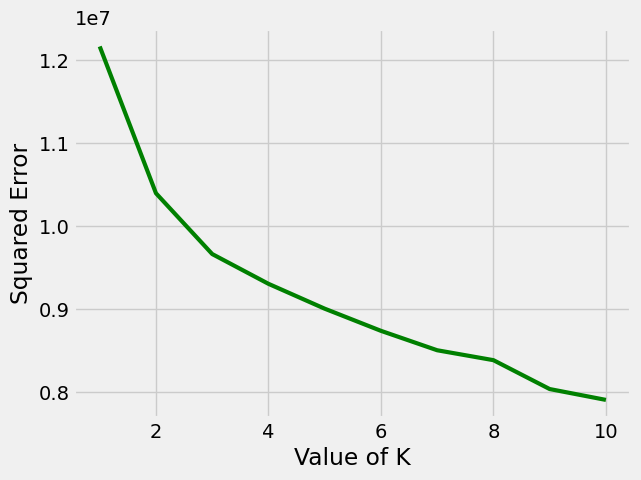

In [61]:
numeroK = []
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(df_poliza_train)
    numeroK.append(KM.inertia_)    

    
plt.plot(range(1, 11), numeroK, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error")
plt.show()

##### Voy a utilizar 4 clusters ya que a partir de este número la curva se suaviza

In [62]:
kmeans_poliza = KMeans(n_clusters=4).fit(df_poliza_train)
centroids = kmeans_poliza.cluster_centers_
etiquetas = kmeans_poliza.labels_
centroids

array([[ 5.06384957e-02, -2.45004782e-02, -1.72429487e-01,
         1.37846588e-01,  2.06506859e-01, -3.02949881e-01,
        -2.76950406e-03,  1.92194722e+00, -1.93860116e+00,
        -3.89067875e-01,  8.89080734e-01,  1.19986914e-01,
         2.94459105e-01,  8.99290534e-01,  1.89756338e+00,
        -1.95490595e+00,  1.91647012e+00,  1.83584211e+00,
        -3.45991219e-01, -8.01035118e-01, -7.68594353e-01,
        -2.69037235e-01,  1.55075701e+00,  1.53644416e+00,
         5.14361965e-02,  2.36334243e-01,  4.21400099e-01,
        -3.73421310e-01,  0.00000000e+00, -1.14655527e-02,
        -1.66208744e-03, -3.26282487e-02,  6.49678412e-01,
         2.16265351e-01, -2.71471187e-01,  4.07819516e-02,
         7.48563171e-02,  8.83032243e-02,  8.75268637e-03,
         3.58421193e-02, -6.73154296e-02, -5.15274177e-02,
        -9.01682477e-04,  4.32476031e-02,  2.37161855e-03,
        -1.21324503e-02,  9.58342969e-03, -5.25482745e-03,
        -2.02239136e-02,  1.60914188e-02, -1.60914188e-0

In [63]:
df_poliza_train["cluster_poliza"] = kmeans_poliza.predict(df_poliza_train)

In [64]:
df_poliza_number_cluster = df_poliza_train.groupby("cluster_poliza")[["CoverageField11"]].agg('count')
df_poliza_number_cluster.rename(columns = {"CoverageField11": "Count"})

,Count
cluster_poliza,
0,39789
1,40540
2,38879
3,37243


# 4.- Haciendo uso del dataset de entrenamiento de train.csv y la variable QuoteConversion_Flag , calcula el valor esperado de éxito para clúster de campañas mostrado a cada clúster de clientes. Este valor esperado, podría representar, de forma aproximada, por cada combinación de clusters campaña-cliente, la probabilidad de éxito al ofrecer una campaña al azar de un clúster de pólizas a un cliente al azar de un clúster de clientes. 

In [65]:
ej4 = pd.merge(df_poliza_train[["cluster_poliza"]], df_clientes_n[["cluster_clientes", "QuoteConversion_Flag"]], left_index=True, right_index=True)
ej4

,cluster_poliza,cluster_clientes,QuoteConversion_Flag
0,1,1,0.0
1,2,0,0.0
3,0,2,0.0
4,2,2,0.0
6,0,2,0.0
...,...,...,...
260746,2,0,0.0
260749,0,2,0.0
260750,2,0,0.0
260751,1,0,0.0


In [66]:
ej4_1 = ej4[ej4.QuoteConversion_Flag == 1]

In [67]:
ej4_exito = pd.crosstab(ej4_1.cluster_poliza, ej4_1.cluster_clientes) / pd.crosstab(ej4.cluster_poliza, ej4.cluster_clientes)
ej4_exito

cluster_clientes,0,1,2,3
cluster_poliza,,,,
0,0.050000,NaN,0.056276,0.079905
1,0.263212,0.183506,0.123944,0.095188
2,0.320824,0.274171,0.149928,0.148070
3,0.364995,0.220514,0.133333,0.000000


##### Conclusiones: 
* Gracias a esta tabla de éxito podemos concluir que si metengo un cliente potencial del cluster 0, debería ofrecerla la póliza 1 porque es la que más convierte para ese nicho.
* Así podríamos hacer con los demás. A los clientes de tipo 1 debería ofrecerles la póliza 0 o 1, a los clientes 2 nunca deberé ofrecerle la póliza 3 pero sí cualquier otra y a los clientes de tipo 3 o la póliza 1

# 5.- Evalúa cómo de preciso son los modelos que hemos creado, contrastando los contra el set de test.  A cada registro de test le asignas el cluster al que pertenece el cliente y el cluster al que pertenece la póliza, asigna la tasa de éxito estimada en entrenamiento. Usa la tasa de aceptación estimada como una probabilidad, establece un valor de corte a partir del cuál consideramos que será aceptada, y compara los resultados estimados con el valor real de la variable QuoteConversion_Flag, ¿cuál es el porcentaje de acierto?

#####
* Ahora que tengo los DataFrame de test de clientes y de póliza lo que hago es realizar un cluster para ellos asignandoles un grupo: 

In [68]:
df_clientes_test["cluster_clientes_test"] = kmeans_cliente.predict(df_clientes_test)
df_poliza_test["cluster_poliza_test"] = kmeans_poliza.predict(df_poliza_test)

In [69]:
ej5 = pd.merge(df_poliza_test[["cluster_poliza_test"]], df_clientes_test[["cluster_clientes_test", "QuoteConversion_Flag"]], left_index=True, right_index=True)
ej5

,cluster_poliza_test,cluster_clientes_test,QuoteConversion_Flag
5,0,2,0.0
10,3,1,0.0
15,0,2,0.0
16,3,1,0.0
18,1,1,0.0
...,...,...,...
260739,1,1,0.0
260741,2,0,0.0
260745,0,3,0.0
260747,2,0,1.0


In [70]:
ej5_1 = ej5[ej5.QuoteConversion_Flag == 1]

In [71]:
ej5_exito = pd.crosstab(ej5_1.cluster_poliza_test, ej5_1.cluster_clientes_test) / pd.crosstab(ej5.cluster_poliza_test, ej5.cluster_clientes_test)
ej5_exito

cluster_clientes_test,0,1,2,3
cluster_poliza_test,,,,
0,0.000000,NaN,0.055731,0.081404
1,0.265047,0.185659,0.126183,0.089404
2,0.320679,0.271805,0.153109,0.144472
3,0.371517,0.220764,1.000000,0.000000


### Vemos la difencia que existe entre train y test
* Lo que estamos buscando al fin y al cabo es que cuando venga un nuevo cliente potencial hacertemos la poliza que le ofrecemos, de ahí la importancia de que este resultado de la tabla de a continuaciñon sea coherente. Si no es así todo el trabajo previo no habrá servido para nada ya que podremos haber sabido calcular los datos con los datos de entrenamiento pero fallaremos al asignar a un nuevo cliente una póliza por lo que cometeremos un grave error. Como "equipo" de Data Science de la compañía Homesite debemos dar a negocio la respuesta correcta según el tipo de cliente al que nos enfrentemos en un futuro 
* Gracias al buen análisis realizado, vemos como se confunde en test muy pocas veces 

In [72]:
abs(ej5_exito - ej4_exito)

cluster_clientes_test,0,1,2,3
cluster_poliza_test,,,,
0,0.050000,NaN,0.000545,0.001499
1,0.001835,0.002153,0.002239,0.005784
2,0.000145,0.002366,0.003181,0.003597
3,0.006522,0.000251,0.866667,0.000000


### Error cuadrático medio

In [73]:
ej4["uno"] = 1
ej5["uno"] = 1
exito_ej4 = ej4.groupby(["cluster_poliza","cluster_clientes"]).sum().reset_index()
exito_ej5 = ej5.groupby(["cluster_poliza_test","cluster_clientes_test"]).sum().reset_index()
exito_ej4["Exito_train"] = (exito_ej4.QuoteConversion_Flag/exito_ej4.uno)*100
exito_ej5["Exito_test"] = (exito_ej5.QuoteConversion_Flag/exito_ej5.uno)*100

comparacion = exito_ej4
comparacion["Exito_test"] = exito_ej5.Exito_test.values
comparacion["Diferencia"] = abs(comparacion.Exito_train - comparacion.Exito_test)

general_error = mean_squared_error(comparacion.Exito_test, comparacion.Exito_train)
print("Error cuadrático medio entre train y test " + str(round(general_error, 2)) + "%")

Error cuadrático medio entre train y test 502.49%


#  6.- Genera datos simulados:

### Primero elegimos un cliente al hazar

In [74]:
import random
cliente_random = random.choice(df_clientes_n.index)
cliente_random

76327

In [75]:
cluster_cliente_random = df_clientes_n.cluster_clientes.loc[cliente_random]
cluster_cliente_random

2

In [76]:
tabla_cliente_random = comparacion[comparacion.cluster_clientes == cluster_cliente_random].sort_values(by = "Exito_train", ascending = False)
tabla_cliente_random

,cluster_poliza,cluster_clientes,QuoteConversion_Flag,uno,Exito_train,Exito_test,Diferencia
9,2,2,1663.0,11092,14.992788,15.310874,0.318086
13,3,2,2.0,15,13.333333,100.000000,86.666667
5,1,2,455.0,3671,12.394443,12.618297,0.223854
1,0,2,1788.0,31772,5.627597,5.573130,0.054467


In [77]:
print("Para el cliente elegido al hazar numero " + str(cliente_random) + " se ha elegido el cluster " + str(cluster_cliente_random) + 
     " y se debería ofrecerle la poliza " + str(tabla_cliente_random.cluster_poliza[1]) + " ya que lo contrataría normalmente el " + 
      str(round(tabla_cliente_random.Exito_train[1], 2)) + "% de las veces")

Para el cliente elegido al hazar numero 76327 se ha elegido el cluster 2 y se debería ofrecerle la poliza 0 ya que lo contrataría normalmente el 5.63% de las veces


###  Segundo elegimos una poliza al hazar

In [78]:
poliza_random = random.choice(df_poliza_train.index)
poliza_random

254828

In [79]:
cluster_poliza_random = df_poliza_train.cluster_poliza.loc[poliza_random]
cluster_poliza_random

0

In [80]:
tabla_poliza_random = comparacion[comparacion.cluster_poliza == cluster_poliza_random].sort_values(by = "Exito_train", ascending = False)
tabla_poliza_random

,cluster_poliza,cluster_clientes,QuoteConversion_Flag,uno,Exito_train,Exito_test,Diferencia
2,0,3,639.0,7997,7.990496,8.140403,0.149907
1,0,2,1788.0,31772,5.627597,5.573130,0.054467
0,0,0,1.0,20,5.000000,0.000000,5.000000


In [82]:
print("Para la poliza elegido al hazar numero " + str(poliza_random) + " se ha elegido el cluster " + str(cluster_poliza_random) + 
     " y se debería ofrecerle la poliza " + str(tabla_poliza_random.cluster_clientes[0]) + " ya que lo contrataría normalmente el " + 
      str(round(tabla_poliza_random.Exito_train[0], 2)) + "% de las veces")

Para la poliza elegido al hazar numero 254828 se ha elegido el cluster 0 y se debería ofrecerle la poliza 0 ya que lo contrataría normalmente el 5.0% de las veces
